In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline

### S&P since 1993

In [2]:
df_spy = pd.read_csv('SPY1993.csv')
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547974,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729685,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784193,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165783,531500


In [3]:
df_spy = df_spy.sort_values(by='Date')
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547974,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729685,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784193,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165783,531500


In [4]:
## pulls last date in every year

df_spy_yrend = df_spy.groupby(pd.DatetimeIndex(df_spy.Date).to_period('Y'), as_index=False).nth(-1)
df_spy_yrend.head()

,Date,Open,High,Low,Close,Adj Close,Volume
233,1993-12-31,46.937500,47.00000,46.56250,46.593750,27.772987,312900
485,1994-12-30,46.203125,46.25000,45.56250,45.562500,27.883350,2209500
737,1995-12-29,61.468750,61.53125,61.25000,61.484375,38.492661,339200
991,1996-12-31,75.281250,75.37500,73.84375,73.843750,47.152527,1378100
1244,1997-12-31,96.875000,97.62500,96.68750,97.062500,62.936913,4359500


In [5]:
df_spy_yrend[["year", "month", "day"]] = df_spy_yrend["Date"].str.split("-", expand = True)
df_spy_yrend['yyyy-mm'] = df_spy_yrend['year'] + '-' + df_spy_yrend['month']

df_agg = df_spy_yrend.groupby('year', as_index=False).agg({'High':'max', 'Low':'min', 'Adj Close':'mean'})
df_agg.rename(columns={'High':'high', 'Low':'low', 'Adj Close':'adj_close'}, inplace=True)
df_agg.head()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_4826/278511491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spy_yrend['yyyy-mm'] = df_spy_yrend['year'] + '-' + df_spy_yrend['month']


,year,high,low,adj_close
0,1993,47.00000,46.56250,27.772987
1,1994,46.25000,45.56250,27.883350
2,1995,61.53125,61.25000,38.492661
3,1996,75.37500,73.84375,47.152527
4,1997,97.62500,96.68750,62.936913


In [6]:
## find diff in price in S&P between years

df_agg['pct_change_adj_close'] = df_agg['adj_close'].pct_change()
df_agg.head()

,year,high,low,adj_close,pct_change_adj_close
0,1993,47.00000,46.56250,27.772987,NaN
1,1994,46.25000,45.56250,27.883350,0.003974
2,1995,61.53125,61.25000,38.492661,0.380489
3,1996,75.37500,73.84375,47.152527,0.224974
4,1997,97.62500,96.68750,62.936913,0.334752


In [7]:
## goal when investing: low volatility

df_agg['volatility'] = (df_agg['high'] - df_agg['low']) / df_agg['adj_close']
df_agg.head()

,year,high,low,adj_close,pct_change_adj_close,volatility
0,1993,47.00000,46.56250,27.772987,NaN,0.015753
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896


In [8]:
df_agg['year'] = df_agg['year'].astype(int) 
df_agg.head()

,year,high,low,adj_close,pct_change_adj_close,volatility
0,1993,47.00000,46.56250,27.772987,NaN,0.015753
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896


#### LP Commitments (lp_commitments.csv)

In [9]:
## year by year LP commitments

df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp = df_lp.sort_values('vintage_year', ascending=False)
df_lp = df_lp[df_lp['vintage_year'] != 0]
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [10]:
df_lp_grouped = df_lp.groupby('vintage_year',as_index=False).agg({'fund_size_amt':'mean', 'commitment_amt':'mean'})
df_lp_grouped = df_lp_grouped.sort_values('vintage_year', ascending=False)
df_lp_grouped = df_lp_grouped.rename(columns={'fund_size_amt':'avg_fund_size_amt', 
                                              'commitment_amt':'avg_commitment_amt'})
df_lp_grouped.head()

,vintage_year,avg_fund_size_amt,avg_commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08


In [11]:
## merge S&P data with LP Commitment data

df_lp_merge = df_lp_grouped.rename(columns={'vintage_year':'year'})

df_merged = pd.merge(df_agg, df_lp_merge, on='year')
df_merged = df_merged.sort_values('year')
df_merged.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,avg_commitment_amt
0,1993,47.00000,46.56250,27.772987,NaN,0.015753,4.719266e+08,1.149871e+07
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656,3.385642e+08,1.182192e+07
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307,6.591820e+08,1.560681e+07
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474,6.750360e+08,1.330191e+07
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896,8.160065e+08,1.211518e+07


In [12]:
## look at percent changes in allocation of funds

df_merged['pct_change_fund_size_amt'] = df_merged['avg_fund_size_amt'].pct_change()
df_merged['pct_change_commit_amt'] = df_merged['avg_commitment_amt'].pct_change()

df_merged = df_merged.rename(columns={'avg_commitment_amt':'avg_commit_amt'})
df_merged = df_merged[['year', 'high', 'low', 'adj_close', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_size_amt',
                      'avg_commit_amt', 'pct_change_commit_amt']]

df_merged.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt
0,1993,47.00000,46.56250,27.772987,NaN,0.015753,4.719266e+08,NaN,1.149871e+07,NaN
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656,3.385642e+08,-0.282591,1.182192e+07,0.028109
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307,6.591820e+08,0.946992,1.560681e+07,0.320158
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474,6.750360e+08,0.024051,1.330191e+07,-0.147685
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896,8.160065e+08,0.208834,1.211518e+07,-0.089215


In [13]:
## percent changes for emerging funds in particular

df_emerging = df_merged[df_merged['avg_fund_size_amt'] <= 250000000]
df_emerging.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt


##### No average fund size less than or equal to $250M in LP Commitments data

In [14]:
## correlations

df_merged['pct_change_adj_close'].corr(df_merged['pct_change_fund_size_amt'])

0.11968294100221738

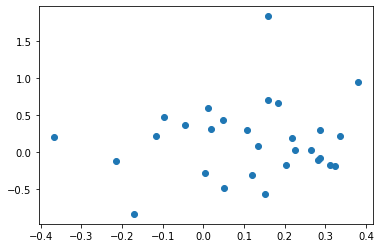

In [15]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.pct_change_fund_size_amt)

In [16]:
df_merged['pct_change_adj_close'].corr(df_merged['avg_fund_size_amt'])

0.07250687220510116

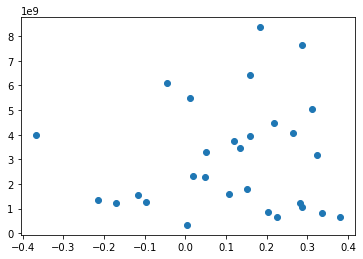

In [17]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.avg_fund_size_amt)

In [18]:
df_merged['volatility'].corr(df_merged['pct_change_fund_size_amt'])

-0.09295513542178833

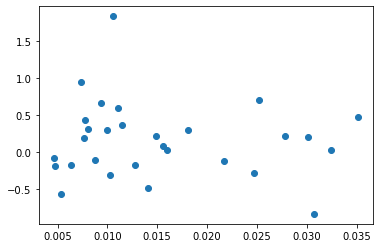

In [19]:
plt.scatter(df_merged.volatility, df_merged.pct_change_fund_size_amt)

In [20]:
df_merged['volatility'].corr(df_merged['avg_fund_size_amt'])

-0.3861680234575997

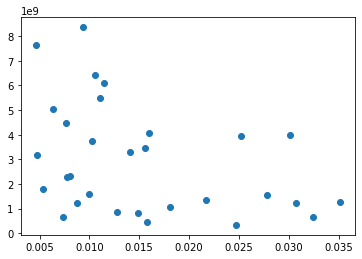

In [21]:
plt.scatter(df_merged.volatility, df_merged.avg_fund_size_amt)

In [22]:
df_merged['pct_change_adj_close'].corr(df_merged['pct_change_commit_amt'])

-0.019635452545019774

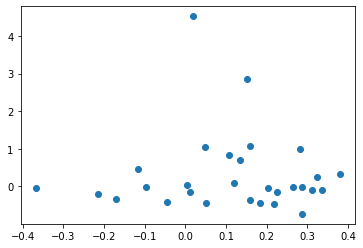

In [23]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.pct_change_commit_amt)

In [24]:
df_merged['pct_change_adj_close'].corr(df_merged['avg_commit_amt'])

0.08788007257110932

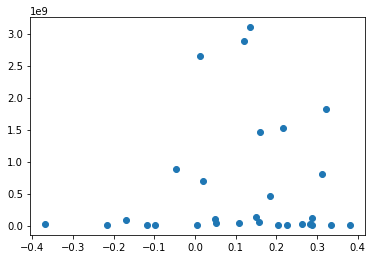

In [25]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.avg_commit_amt)

In [26]:
df_merged['volatility'].corr(df_merged['pct_change_commit_amt'])

-0.215800967194689

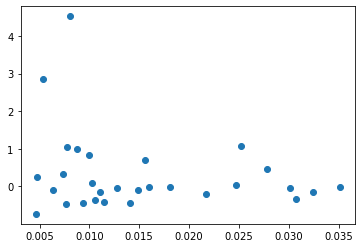

In [27]:
plt.scatter(df_merged.volatility, df_merged.pct_change_commit_amt)

In [28]:
df_merged['volatility'].corr(df_merged['avg_commit_amt'])

-0.2487675677977096

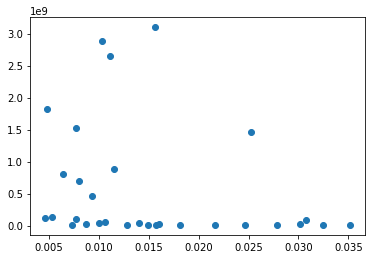

In [29]:
plt.scatter(df_merged.volatility, df_merged.avg_commit_amt)

In [30]:
df_merged.avg_fund_size_amt.nsmallest(5)

1    3.385642e+08
0    4.719266e+08
2    6.591820e+08
3    6.750360e+08
4    8.160065e+08
Name: avg_fund_size_amt, dtype: float64

#### Buyouts Funds (buyouts_funds_final.csv)

In [31]:
## retrying with year by year funds data

df_funds = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')
df_funds = df_funds.sort_values('vintage_year', ascending=False)
df_funds = df_funds[df_funds['vintage_year'] != 0]
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
6950,62131,Corridor Capital Title II,12869,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,13260000.0,USD,Launched,NaN,2022,2022-4
6177,61228,Altera Vision PA,22927,Venture Capital / Growth Equity,Diversified,North America,NaN,5250000.0,USD,3560000.0,USD,Currently Investing,1st Close,2022,2022-2
6193,61238,Third Lake PC NCBDC Fund,20727,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-2
6192,61237,Barings CMS Fund,2161,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-0
6189,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Middle East/Africa,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3


In [32]:
df_funds = df_funds[['vintage_year', 'fund_size_amt', 'target_fund_size_amt']]
df_funds.head()

,vintage_year,fund_size_amt,target_fund_size_amt
6950,2022,13260000.0,NaN
6177,2022,3560000.0,5250000.0
6193,2022,NaN,NaN
6192,2022,NaN,NaN
6189,2022,NaN,200000000.0


In [33]:
df_funds_grouped = df_funds.groupby('vintage_year', as_index=False).agg({'fund_size_amt':'mean',
                                                                        'target_fund_size_amt':'mean'})
df_funds_grouped = df_funds_grouped.sort_values('vintage_year', ascending=False)
df_funds_grouped = df_funds_grouped.rename(columns={'vintage_year':'year', 'fund_size_amt':'avg_fund_size_amt',
                                                   'target_fund_size_amt':'avg_target_fund_size_amt'})
df_funds_grouped.head()

,year,avg_fund_size_amt,avg_target_fund_size_amt
3,2022,3.468283e+08,3.293141e+09
2,2021,8.073735e+08,1.833711e+09
1,2020,4.589803e+08,1.141979e+09
0,2019,1.436815e+09,3.027148e+08


In [34]:
## merge S&P data with funds data

df_merged2 = pd.merge(df_agg, df_funds_grouped, on='year')
df_merged2 = df_merged2.sort_values('year')
df_merged2.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,avg_target_fund_size_amt
0,2019,322.130005,320.149994,310.837585,0.312239,0.006370,1.436815e+09,3.027148e+08
1,2020,374.660004,371.230011,367.819122,0.183316,0.009325,4.589803e+08,1.141979e+09
2,2021,476.859985,474.670013,473.489044,0.287288,0.004625,8.073735e+08,1.833711e+09
3,2022,404.040009,391.959991,392.750000,-0.170519,0.030758,3.468283e+08,3.293141e+09


In [35]:
## look at percent changes in allocation of funds

df_merged2['pct_change_fund_amt'] = df_merged2['avg_fund_size_amt'].pct_change()
df_merged2['pct_change_target_amt'] = df_merged2['avg_target_fund_size_amt'].pct_change()

df_merged2 = df_merged2[['year', 'high', 'low', 'adj_close', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_amt',
                      'avg_target_fund_size_amt', 'pct_change_target_amt']]

df_merged2.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,2019,322.130005,320.149994,310.837585,0.312239,0.006370,1.436815e+09,NaN,3.027148e+08,NaN
1,2020,374.660004,371.230011,367.819122,0.183316,0.009325,4.589803e+08,-0.680557,1.141979e+09,2.772458
2,2021,476.859985,474.670013,473.489044,0.287288,0.004625,8.073735e+08,0.759059,1.833711e+09,0.605731
3,2022,404.040009,391.959991,392.750000,-0.170519,0.030758,3.468283e+08,-0.570424,3.293141e+09,0.795889


In [36]:
## percent changes for emerging funds in particular

df_emerging2 = df_merged2[df_merged2['avg_fund_size_amt'] <= 250000000]
df_emerging2.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt


##### No average fund size less than or equal to $250M in Funds data

In [37]:
## correlations

df_merged2['pct_change_adj_close'].corr(df_merged2['pct_change_fund_amt'])

0.6234590837464378

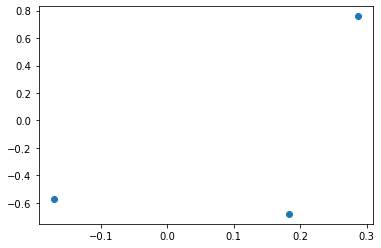

In [38]:
plt.scatter(df_merged2.pct_change_adj_close, df_merged2.pct_change_fund_amt)

In [39]:
df_merged2['pct_change_adj_close'].corr(df_merged2['avg_fund_size_amt'])

0.7279554094232358

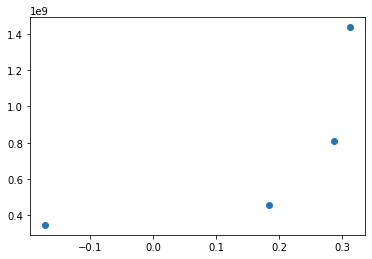

In [40]:
plt.scatter(df_merged2.pct_change_adj_close, df_merged2.avg_fund_size_amt)

In [41]:
df_merged2['volatility'].corr(df_merged2['pct_change_fund_amt'])

-0.5845520724135566

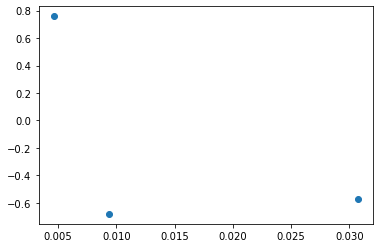

In [42]:
plt.scatter(df_merged2.volatility, df_merged2.pct_change_fund_amt)

In [43]:
df_merged2['volatility'].corr(df_merged2['avg_fund_size_amt'])

-0.6217189931930354

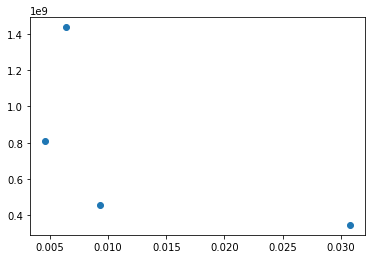

In [44]:
plt.scatter(df_merged2.volatility, df_merged2.avg_fund_size_amt)

In [45]:
df_merged2.avg_fund_size_amt.nsmallest(5)

3    3.468283e+08
1    4.589803e+08
2    8.073735e+08
0    1.436815e+09
Name: avg_fund_size_amt, dtype: float64

#### Buyouts Fund Manager History (buyouts_fm_fund_history.csv)

In [46]:
## retrying with year by year fund history data

df_fund_hist = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_fm_fund_history.csv')
df_fund_hist = df_fund_hist.sort_values('vintage_year', ascending=False)
df_fund_hist = df_fund_hist[df_fund_hist['vintage_year'] != 0]
df_fund_hist.head()

,fm_fund_id,fm_id,fund_id,fund_name,vintage_year,region,sector,strategy,fund_size_amt,fund_currency,target_fund_size_amt,target_fund_size_currency
28568,14887,6373,60838,Apax XI,2022,Western Europe,Healthcare,Buyout / Corporate Private Equity,0.0,USD,1.300000e+10,USD
16926,12203,20421,62041,Imaginary Venture Capital EIP Fund III,2022,North America,TMT,Venture Capital / Growth Equity,2250000.0,USD,3.000000e+06,USD
25878,12592,7918,61341,NVP X,2022,North America,Diversified,Fund of Funds / Co-Investment,58120000.0,USD,2.000000e+08,USD
25877,8189,7918,61341,NVP X,2022,Asia-Pacific,Diversified,Fund of Funds / Co-Investment,58120000.0,USD,2.000000e+08,USD
1481,81,19359,60588,Two Sigma Ventures Opportunity Fund II,2022,North America,TMT,Venture Capital / Growth Equity,0.0,USD,0.000000e+00,USD


In [47]:
df_fund_hist = df_fund_hist[['vintage_year', 'fund_size_amt', 'target_fund_size_amt']]
df_fund_hist.head()

,vintage_year,fund_size_amt,target_fund_size_amt
28568,2022,0.0,1.300000e+10
16926,2022,2250000.0,3.000000e+06
25878,2022,58120000.0,2.000000e+08
25877,2022,58120000.0,2.000000e+08
1481,2022,0.0,0.000000e+00


In [48]:
df_fund_hist_grouped = df_fund_hist.groupby('vintage_year', as_index=False).agg({'fund_size_amt':'mean',
                                                                        'target_fund_size_amt':'mean'})
df_fund_hist_grouped = df_fund_hist_grouped.sort_values('vintage_year', ascending=False)
df_fund_hist_grouped = df_fund_hist_grouped.rename(columns={'vintage_year':'year',
                                                            'fund_size_amt':'avg_fund_size_amt',
                                                   'target_fund_size_amt':'avg_target_fund_size_amt'})
df_fund_hist_grouped.head()

,year,avg_fund_size_amt,avg_target_fund_size_amt
46,2022,1.229488e+08,1.721153e+09
45,2021,8.103145e+08,1.178290e+09
44,2020,9.503080e+08,9.747711e+08
43,2019,2.318471e+09,1.208510e+09
42,2018,1.510733e+09,1.245684e+09


In [49]:
## merge S&P data with funds data

df_merged3 = pd.merge(df_agg, df_fund_hist_grouped, on='year')
df_merged3 = df_merged3.sort_values('year')
df_merged3.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,avg_target_fund_size_amt
0,1993,47.00000,46.56250,27.772987,NaN,0.015753,5.014138e+08,1.360795e+08
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656,2.476874e+08,1.454302e+08
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307,4.990383e+08,2.676641e+07
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474,3.518425e+08,5.550826e+07
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896,6.744599e+08,2.132325e+08


In [50]:
## look at percent changes in allocation of funds

df_merged3['pct_change_fund_amt'] = df_merged3['avg_fund_size_amt'].pct_change()
df_merged3['pct_change_target_amt'] = df_merged3['avg_target_fund_size_amt'].pct_change()

df_merged3 = df_merged3[['year', 'high', 'low', 'adj_close', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_amt',
                      'avg_target_fund_size_amt', 'pct_change_target_amt']]

df_merged3.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,1993,47.00000,46.56250,27.772987,NaN,0.015753,5.014138e+08,NaN,1.360795e+08,NaN
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656,2.476874e+08,-0.506022,1.454302e+08,0.068715
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307,4.990383e+08,1.014791,2.676641e+07,-0.815950
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474,3.518425e+08,-0.294959,5.550826e+07,1.073803
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896,6.744599e+08,0.916937,2.132325e+08,2.841455


In [51]:
## percent changes for emerging funds in particular

df_emerging3 = df_merged3[df_merged3['avg_fund_size_amt'] <= 250000000]
df_emerging3.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
1,1994,46.250000,45.562500,27.88335,0.003974,0.024656,2.476874e+08,-0.506022,1.454302e+08,0.068715
29,2022,404.040009,391.959991,392.75000,-0.170519,0.030758,1.229488e+08,-0.848270,1.721153e+09,0.460721


##### Average fund sizes in both 1994 and 2022 are the lowest 

In [52]:
## correlations

df_merged3['pct_change_adj_close'].corr(df_merged3['pct_change_fund_amt'])

0.14356006959583786

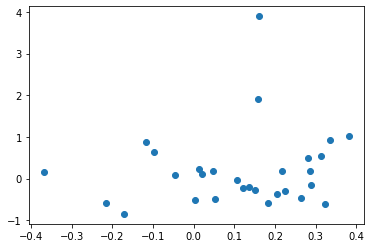

In [53]:
plt.scatter(df_merged3.pct_change_adj_close, df_merged3.pct_change_fund_amt)

In [54]:
df_merged3['pct_change_adj_close'].corr(df_merged3['avg_fund_size_amt'])

0.006328702696983285

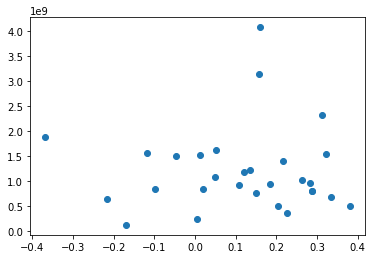

In [55]:
plt.scatter(df_merged3.pct_change_adj_close, df_merged3.avg_fund_size_amt)

In [56]:
df_merged3['volatility'].corr(df_merged3['pct_change_fund_amt'])

0.10399003920576727

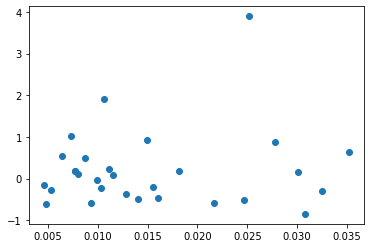

In [57]:
plt.scatter(df_merged3.volatility, df_merged3.pct_change_fund_amt)

In [58]:
df_merged3['volatility'].corr(df_merged3['avg_fund_size_amt'])

-0.055441179109785604

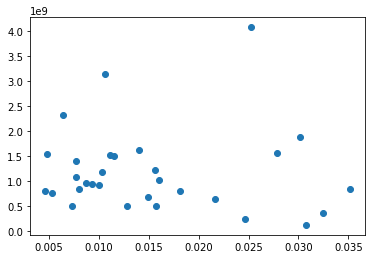

In [59]:
plt.scatter(df_merged3.volatility, df_merged3.avg_fund_size_amt)

#### Buyouts Historical Data (buyouts_historical_funds.csv)

In [60]:
## retrying with year by year fund history data

df_hist = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_historical_funds.csv')
df_hist = df_hist.sort_values('close_year', ascending=False)
df_hist = df_hist[df_hist['close_year'] != 0]
df_hist.head()

,fund_id,fund_name,manager_id,manager,close_year,strategy,fund_size_amt,fund_currency
7158,59510,Coral Tree Fund I,22607.0,Coral Tree Partners,2022,Venture Capital / Growth Equity,450000000.0,USD
7064,61899,Fuse Venture Partners Alpha I,7015.0,Ignition Partners,2022,Venture Capital / Growth Equity,159660000.0,USD
7070,61821,Signal Peak Ventures III CIV-A,12537.0,Signal Peak Ventures,2022,Venture Capital / Growth Equity,50960000.0,USD
7069,61796,Frazier Life Sciences XI,6498.0,Frazier Healthcare Partners,2022,Venture Capital / Growth Equity,960000000.0,USD
7068,62028,Legacy Knight Strategic Opportunities Fund,22886.0,Legacy Knight,2022,Venture Capital / Growth Equity,72620000.0,USD


In [61]:
df_hist = df_hist[['close_year', 'fund_size_amt']]
df_hist.head()

,close_year,fund_size_amt
7158,2022,450000000.0
7064,2022,159660000.0
7070,2022,50960000.0
7069,2022,960000000.0
7068,2022,72620000.0


In [62]:
df_hist_grouped = df_hist.groupby('close_year', as_index=False).agg({'fund_size_amt':'mean'})
df_hist_grouped = df_hist_grouped.sort_values('close_year', ascending=False)
df_hist_grouped = df_hist_grouped.rename(columns={'close_year':'year', 'fund_size_amt':'avg_fund_size_amt'})
df_hist_grouped.head()

,year,avg_fund_size_amt
41,2022,6.614948e+08
40,2021,4.060309e+08
39,2020,2.631996e+08
38,2019,2.745854e+08
37,2018,2.299908e+08


In [63]:
## merge S&P data with fund history data

df_merged4 = pd.merge(df_agg, df_hist_grouped, on='year')
df_merged4 = df_merged4.sort_values('year')
df_merged4.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt
0,1993,47.00000,46.56250,27.772987,NaN,0.015753,1.617220e+08
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656,2.250000e+08
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307,1.640000e+08
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474,1.462857e+08
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896,3.365350e+08


In [64]:
## look at percent changes in allocation of funds

df_merged4['pct_change_fund_amt'] = df_merged4['avg_fund_size_amt'].pct_change()

df_merged4 = df_merged4[['year', 'high', 'low', 'adj_close', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_amt']]

df_merged4.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt
0,1993,47.00000,46.56250,27.772987,NaN,0.015753,1.617220e+08,NaN
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656,2.250000e+08,0.391276
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307,1.640000e+08,-0.271111
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474,1.462857e+08,-0.108014
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896,3.365350e+08,1.300532


In [65]:
## percent changes for emerging funds in particular

df_emerging4 = df_merged4[df_merged4['avg_fund_size_amt'] <= 250000000]
df_emerging4

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt
0,1993,47.000000,46.562500,27.772987,NaN,0.015753,1.617220e+08,NaN
1,1994,46.250000,45.562500,27.883350,0.003974,0.024656,2.250000e+08,0.391276
2,1995,61.531250,61.250000,38.492661,0.380489,0.007307,1.640000e+08,-0.271111
3,1996,75.375000,73.843750,47.152527,0.224974,0.032474,1.462857e+08,-0.108014
5,1998,123.937500,122.468750,80.995041,0.286924,0.018134,1.941444e+08,-0.423108
9,2002,88.430000,87.110001,60.898777,-0.215846,0.021675,1.664290e+08,-0.394498
10,2003,111.519997,110.839996,78.061043,0.281816,0.008711,1.964729e+08,0.180521
11,2004,121.660004,120.800003,86.411926,0.106979,0.009952,2.278578e+08,0.159741
18,2011,126.330002,125.500000,103.304543,0.018950,0.008035,1.942770e+08,-0.521571
19,2012,142.559998,139.539993,119.823288,0.159903,0.025204,2.333471e+08,0.201105


In [66]:
## correlations

df_merged4['pct_change_adj_close'].corr(df_merged4['pct_change_fund_amt'])

0.02279863557873984

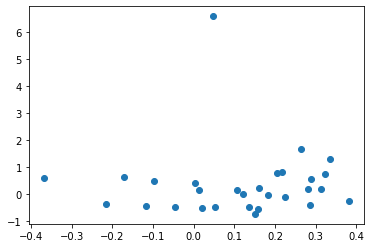

In [67]:
plt.scatter(df_merged4.pct_change_adj_close, df_merged4.pct_change_fund_amt)

In [68]:
df_merged4['pct_change_adj_close'].corr(df_merged4['avg_fund_size_amt'])

-0.058391598215112236

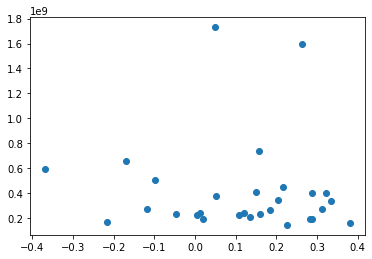

In [69]:
plt.scatter(df_merged4.pct_change_adj_close, df_merged4.avg_fund_size_amt)

In [70]:
df_merged4['volatility'].corr(df_merged4['pct_change_fund_amt'])

-0.09961749515416334

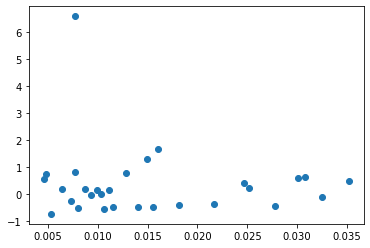

In [71]:
plt.scatter(df_merged4.volatility, df_merged4.pct_change_fund_amt)

In [72]:
df_merged4['volatility'].corr(df_merged4['avg_fund_size_amt'])

-0.03997458194335998

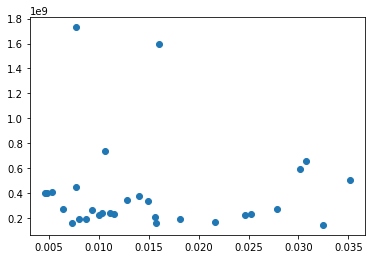

In [73]:
plt.scatter(df_merged4.volatility, df_merged4.avg_fund_size_amt)

In [74]:
## correlations for emerging funds only

df_emerging4['pct_change_adj_close'].corr(df_emerging4['pct_change_fund_amt'])

0.11223063012550955

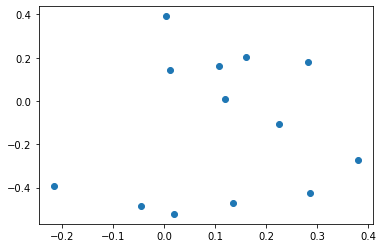

In [75]:
plt.scatter(df_emerging4.pct_change_adj_close, df_emerging4.pct_change_fund_amt)

In [76]:
df_emerging4['pct_change_adj_close'].corr(df_emerging4['avg_fund_size_amt'])

-0.2506289408774063

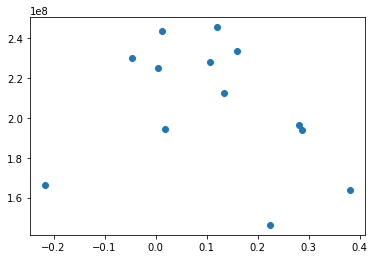

In [77]:
plt.scatter(df_emerging4.pct_change_adj_close, df_emerging4.avg_fund_size_amt)

In [78]:
df_emerging4['volatility'].corr(df_emerging4['pct_change_fund_amt'])

0.18717831014210873

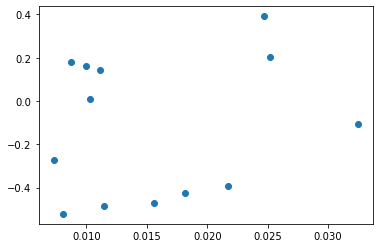

In [79]:
plt.scatter(df_emerging4.volatility, df_emerging4.pct_change_fund_amt)

In [80]:
df_emerging4['volatility'].corr(df_emerging4['avg_fund_size_amt'])

-0.283828584820825

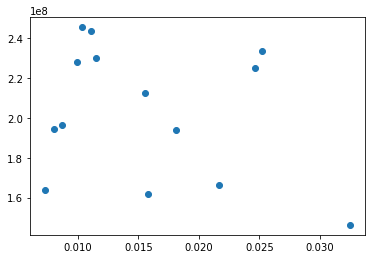

In [81]:
plt.scatter(df_emerging4.volatility, df_emerging4.avg_fund_size_amt)

##### Greater correlation between S&P data and emerging funds specifically

### Linear Regression: S&P vs. LP Commitments (lp_commitments.csv)

In [82]:
df_merged

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt
0,1993,47.000000,46.562500,27.772987,NaN,0.015753,4.719266e+08,NaN,1.149871e+07,NaN
1,1994,46.250000,45.562500,27.883350,0.003974,0.024656,3.385642e+08,-0.282591,1.182192e+07,0.028109
2,1995,61.531250,61.250000,38.492661,0.380489,0.007307,6.591820e+08,0.946992,1.560681e+07,0.320158
3,1996,75.375000,73.843750,47.152527,0.224974,0.032474,6.750360e+08,0.024051,1.330191e+07,-0.147685
4,1997,97.625000,96.687500,62.936913,0.334752,0.014896,8.160065e+08,0.208834,1.211518e+07,-0.089215
5,1998,123.937500,122.468750,80.995041,0.286924,0.018134,1.055814e+09,0.293880,1.185049e+07,-0.021847
6,1999,147.500000,146.250000,97.509422,0.203894,0.012819,8.717311e+08,-0.174352,1.145844e+07,-0.033083
7,2000,134.281250,131.187500,88.010506,-0.097415,0.035152,1.279754e+09,0.468061,1.126401e+07,-0.016968
8,2001,116.389999,114.230003,77.661781,-0.117585,0.027813,1.553750e+09,0.214100,1.636040e+07,0.452449
9,2002,88.430000,87.110001,60.898777,-0.215846,0.021675,1.364562e+09,-0.121762,1.297006e+07,-0.207229


In [83]:
# using all variables to predict pct_change_fund_size_amt

df_merged.dropna(inplace=True)

model_lp1 = LinearRegression()

X_lp1 = df_merged.loc[:, df_merged.columns != 'pct_change_fund_size_amt']
y_lp1 = df_merged.pct_change_fund_size_amt

model_lp1.fit(X_lp1, y_lp1)

rsq_model_lp1 = model_lp1.score(X_lp1, y_lp1)
rsq_model_lp1

0.740485128099988

In [100]:
# verify p-value

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.572
Model:                                  OLS   Adj. R-squared (uncentered):              0.379
Method:                       Least Squares   F-statistic:                              2.965
Date:                      Wed, 25 May 2022   Prob (F-statistic):                      0.0206
Time:                              23:38:47   Log-Likelihood:                         -10.305
No. Observations:                        29   AIC:                                      38.61
Df Residuals:                            20   BIC:                                      50.92
Df Model:                                 9                                                  
Covariance Type:                  nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
year                     -0.0003      0.000     -0.885      0.387      -0.001       0.000
high                      0.1057      0.079      1.332      0.198      -0.060       0.271
low                      -0.0967      0.080     -1.211      0.240      -0.263       0.070
adj_close                -0.0136      0.010     -1.427      0.169      -0.034       0.006
pct_change_adj_close      0.8477      0.588      1.443      0.165      -0.378       2.073
volatility                1.8670     15.763      0.118      0.907     -31.014      34.748
avg_fund_size_amt      2.677e-10   6.29e-11      4.253      0.000    1.36e-10    3.99e-10
avg_commit_amt        -6.558e-11   9.07e-11     -0.723      0.478   -2.55e-10    1.24e-10
pct_change_commit_amt     0.0353      0.090      0.391      0.700      -0.153       0.224
==============================================================================
Omnibus:                        4.403   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                3.012
Skew:                          -0.429   Prob(JB):                        0.222
Kurtosis:                       4.325   Cond. No.                     7.77e+11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.77e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [118]:
X_lp1 = df_merged.drop(columns=['pct_change_fund_size_amt', 'volatility', 'avg_commit_amt', 'pct_change_commit_amt',
                               'year'])

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.535
Model:                                  OLS   Adj. R-squared (uncentered):              0.438
Method:                       Least Squares   F-statistic:                              5.521
Date:                      Thu, 26 May 2022   Prob (F-statistic):                     0.00160
Time:                              12:53:39   Log-Likelihood:                         -11.494
No. Observations:                        29   AIC:                                      32.99
Df Residuals:                            24   BIC:                                      39.82
Df Model:                                 5                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
high                     0.0846      0.060      1.416      0.169      -0.039       0.208
low                     -0.0854      0.062     -1.382      0.180      -0.213       0.042
adj_close               -0.0044      0.004     -1.205      0.240      -0.012       0.003
pct_change_adj_close     0.7186      0.509      1.411      0.171      -0.333       1.770
avg_fund_size_amt     2.331e-10   5.36e-11      4.353      0.000    1.23e-10    3.44e-10
==============================================================================
Omnibus:                        0.798   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.671   Jarque-Bera (JB):                0.252
Skew:                          -0.218   Prob(JB):                        0.882
Kurtosis:                       3.135   Cond. No.                     2.61e+10
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.61e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### weak $\left\lvert t \right\rvert$ and p-values and corresponding relatively low $R^{2}$

In [84]:
# using all variables to predict avg_fund_size_amt

model_lp2 = LinearRegression()

X_lp2 = df_merged.loc[:, df_merged.columns != 'avg_fund_size_amt']
y_lp2 = df_merged.avg_fund_size_amt

model_lp2.fit(X_lp2, y_lp2)

rsq_model_lp2 = model_lp2.score(X_lp2, y_lp2)
rsq_model_lp2

0.9462970776928591

In [102]:
# verify p-value

x_prime2 = sm.add_constant(X_lp2)
model_lp2_ols = sm.OLS(y_lp2, X_lp2)
res_lp2 = model_lp2_ols.fit()
res_lp2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      avg_fund_size_amt   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              37.15
Date:                Wed, 25 May 2022   Prob (F-statistic):                    1.49e-10
Time:                        23:40:59   Log-Likelihood:                         -638.70
No. Observations:                  29   AIC:                                      1295.
Df Residuals:                      20   BIC:                                      1308.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                      1.197e+06   6.99e+05      1.713      0.102   -2.61e+05    2.65e+06
high                     -5.053e+08   1.81e+08     -2.795      0.011   -8.82e+08   -1.28e+08
low                       4.786e+08   1.84e+08      2.601      0.017    9.47e+07    8.62e+08
adj_close                 4.332e+07   2.39e+07      1.811      0.085   -6.57e+06    9.32e+07
pct_change_adj_close     -3.151e+09   1.42e+09     -2.212      0.039   -6.12e+09   -1.79e+08
volatility               -1.127e+10   4.05e+10     -0.278      0.784   -9.58e+10    7.32e+10
pct_change_fund_size_amt  1.774e+09   4.17e+08      4.253      0.000    9.04e+08    2.64e+09
avg_commit_amt               0.2848      0.228      1.250      0.226      -0.190       0.760
pct_change_commit_amt    -2.623e+08   2.26e+08     -1.162      0.259   -7.33e+08    2.08e+08
==============================================================================
Omnibus:                        5.826   Durbin-Watson:                   1.184
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                4.027
Skew:                           0.763   Prob(JB):                        0.134
Kurtosis:                       4.001   Cond. No.                     2.24e+11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.24e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [124]:
X_lp2 = df_merged.drop(columns=['avg_fund_size_amt', 'volatility', 'pct_change_fund_size_amt', 
                                'avg_commit_amt', 'pct_change_commit_amt'])

x_prime2 = sm.add_constant(X_lp2)
model_lp2_ols = sm.OLS(y_lp2, X_lp2)
res_lp2 = model_lp2_ols.fit()
res_lp2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      avg_fund_size_amt   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                              34.90
Date:                Thu, 26 May 2022   Prob (F-statistic):                    2.96e-10
Time:                        16:35:09   Log-Likelihood:                         -649.75
No. Observations:                  29   AIC:                                      1309.
Df Residuals:                      24   BIC:                                      1316.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                  1.074e+06   6.58e+05      1.631      0.116   -2.85e+05    2.43e+06
high                  -6.44e+08   1.82e+08     -3.533      0.002   -1.02e+09   -2.68e+08
low                   6.297e+08   1.85e+08      3.395      0.002    2.47e+08    1.01e+09
adj_close             3.347e+07   3.14e+07      1.065      0.297   -3.14e+07    9.83e+07
pct_change_adj_close -2.853e+09   1.76e+09     -1.625      0.117   -6.48e+09    7.71e+08
==============================================================================
Omnibus:                       10.118   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                8.674
Skew:                           1.241   Prob(JB):                       0.0131
Kurtosis:                       4.010   Cond. No.                     1.35e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### decent $\left\lvert t \right\rvert$ and p-values and corresponding high $R^{2}$. Therefore, using year, avg high, avg low, avg adjusted close, and percent change in adjusted close to predict the average fund size shows us decently significant results.

In [85]:
# using all variables to predict pct_change_commit_amt

model_lp3 = LinearRegression()

X_lp3 = df_merged.loc[:, df_merged.columns != 'pct_change_commit_amt']
y_lp3 = df_merged.pct_change_commit_amt

model_lp3.fit(X_lp3, y_lp3)

rsq_model_lp3 = model_lp3.score(X_lp3, y_lp3)
rsq_model_lp3

0.6265226488312736

In [103]:
# verify p-value

x_prime3 = sm.add_constant(X_lp3)
model_lp3_ols = sm.OLS(y_lp3, X_lp3)
res_lp3 = model_lp3_ols.fit()
res_lp3.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     pct_change_commit_amt   R-squared (uncentered):                   0.401
Model:                               OLS   Adj. R-squared (uncentered):              0.132
Method:                    Least Squares   F-statistic:                              1.489
Date:                   Wed, 25 May 2022   Prob (F-statistic):                       0.219
Time:                           23:41:16   Log-Likelihood:                         -36.512
No. Observations:                     29   AIC:                                      91.02
Df Residuals:                         20   BIC:                                      103.3
Df Model:                              9                                                  
Covariance Type:               nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                         0.0017      0.001      2.799      0.011       0.000       0.003
high                         0.0165      0.204      0.081      0.936      -0.410       0.443
low                         -0.0425      0.204     -0.208      0.837      -0.468       0.383
adj_close                    0.0225      0.024      0.927      0.365      -0.028       0.073
pct_change_adj_close        -1.8353      1.468     -1.250      0.226      -4.897       1.226
volatility                 -74.1956     35.215     -2.107      0.048    -147.653      -0.739
avg_fund_size_amt        -2.412e-10   2.08e-10     -1.162      0.259   -6.74e-10    1.92e-10
pct_change_fund_size_amt     0.2152      0.550      0.391      0.700      -0.932       1.362
avg_commit_amt             1.02e-10   2.26e-10      0.452      0.656   -3.69e-10    5.73e-10
==============================================================================
Omnibus:                       21.598   Durbin-Watson:                   1.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.762
Skew:                           1.723   Prob(JB):                     7.69e-08
Kurtosis:                       6.904   Cond. No.                     7.03e+11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.03e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
# using all variables to predict avg_commit_amt

model_lp4 = LinearRegression()

X_lp4 = df_merged.loc[:, df_merged.columns != 'avg_commit_amt']
y_lp4 = df_merged.avg_commit_amt

model_lp4.fit(X_lp4, y_lp4)

rsq_model_lp4 = model_lp4.score(X_lp4, y_lp4)
rsq_model_lp4

0.5787521976049862

In [104]:
# verify p-value

x_prime4 = sm.add_constant(X_lp4)
model_lp4_ols = sm.OLS(y_lp4, X_lp4)
res_lp4 = model_lp4_ols.fit()
res_lp4.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         avg_commit_amt   R-squared (uncentered):                   0.415
Model:                            OLS   Adj. R-squared (uncentered):              0.152
Method:                 Least Squares   F-statistic:                              1.579
Date:                Wed, 25 May 2022   Prob (F-statistic):                       0.189
Time:                        23:41:38   Log-Likelihood:                         -637.07
No. Observations:                  29   AIC:                                      1292.
Df Residuals:                      20   BIC:                                      1304.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                      1.296e+05   7.07e+05      0.183      0.856   -1.34e+06     1.6e+06
high                      1.412e+08   1.99e+08      0.709      0.486   -2.74e+08    5.56e+08
low                      -1.411e+08   1.99e+08     -0.710      0.486   -5.56e+08    2.74e+08
adj_close                -3.348e+06   2.44e+07     -0.137      0.892   -5.42e+07    4.75e+07
pct_change_adj_close      5.944e+08    1.5e+09      0.397      0.695   -2.53e+09    3.72e+09
volatility               -1.886e+10   3.81e+10     -0.495      0.626   -9.84e+10    6.07e+10
avg_fund_size_amt            0.2545      0.204      1.250      0.226      -0.170       0.679
pct_change_fund_size_amt -3.884e+08   5.37e+08     -0.723      0.478   -1.51e+09    7.32e+08
pct_change_commit_amt     9.908e+07   2.19e+08      0.452      0.656   -3.58e+08    5.57e+08
==============================================================================
Omnibus:                       11.510   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.367
Skew:                           1.342   Prob(JB):                      0.00561
Kurtosis:                       4.174   Cond. No.                     7.60e+11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.6e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Highest $R^{2}$ value occurred when using all variables to predict the average fund size amount.

### Linear Regression: S&P vs. Buyouts Funds (buyouts_funds_final.csv)

In [87]:
df_merged2

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,2019,322.130005,320.149994,310.837585,0.312239,0.006370,1.436815e+09,NaN,3.027148e+08,NaN
1,2020,374.660004,371.230011,367.819122,0.183316,0.009325,4.589803e+08,-0.680557,1.141979e+09,2.772458
2,2021,476.859985,474.670013,473.489044,0.287288,0.004625,8.073735e+08,0.759059,1.833711e+09,0.605731
3,2022,404.040009,391.959991,392.750000,-0.170519,0.030758,3.468283e+08,-0.570424,3.293141e+09,0.795889


In [88]:
# using all variables to predict pct_change_fund_amt

df_merged2.dropna(inplace=True)

model_funds_final1 = LinearRegression()

X_funds_final1 = df_merged2.loc[:, df_merged2.columns != 'pct_change_fund_amt']
y_funds_final1 = df_merged2.pct_change_fund_amt

model_funds_final1.fit(X_funds_final1, y_funds_final1)

rsq_model_funds_final1 = model_funds_final1.score(X_funds_final1, y_funds_final1)
rsq_model_funds_final1

1.0

In [105]:
# verify p-value

x_prime_funds1 = sm.add_constant(X_funds_final1)
model_funds_final1 = sm.OLS(y_funds_final1, X_funds_final1)
res_funds1 = model_funds_final1.fit()
res_funds1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarn

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                    nan
Method:                  Least Squares   F-statistic:                       nan
Date:                 Wed, 25 May 2022   Prob (F-statistic):                nan
Time:                         23:42:59   Log-Likelihood:                 64.471
No. Observations:                    3   AIC:                            -122.9
Df Residuals:                        0   BIC:                            -125.6
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                        -0.0013        inf         -0        nan         nan         nan
high                        -0.0001        inf         -0        nan         nan         nan
low                         -0.0001        inf         -0        nan         nan         nan
adj_close                   -0.0001        inf         -0        nan         nan         nan
pct_change_adj_close     -4.821e-08        inf         -0        nan         nan         nan
volatility               -8.451e-09        inf         -0        nan         nan         nan
avg_fund_size_amt          3.76e-09        inf          0        nan         nan         nan
avg_target_fund_size_amt  2.534e-10        inf          0        nan         nan         nan
pct_change_target_amt    -3.663e-06        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.354
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.328
Skew:                          -0.305   Prob(JB):                        0.849
Kurtosis:                       1.500   Cond. No.                     5.46e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The condition number is large, 5.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
# using all variables to predict avg_fund_size_amt

model_funds_final2 = LinearRegression()

X_funds_final2 = df_merged2.loc[:, df_merged2.columns != 'avg_fund_size_amt']
y_funds_final2 = df_merged2.avg_fund_size_amt

model_funds_final2.fit(X_funds_final2, y_funds_final2)

rsq_model_funds_final2 = model_funds_final2.score(X_funds_final2, y_funds_final2)
rsq_model_lp2

0.9462970776928591

In [106]:
# verify p-value

x_prime_funds2 = sm.add_constant(X_funds_final2)
model_funds_final2 = sm.OLS(y_funds_final2, X_funds_final2)
res_funds2 = model_funds_final2.fit()
res_funds2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarn

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      avg_fund_size_amt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 25 May 2022   Prob (F-statistic):                nan
Time:                        23:43:24   Log-Likelihood:                0.53705
No. Observations:                   3   AIC:                             4.926
Df Residuals:                       0   BIC:                             2.222
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                     -4.549e+05        inf         -0        nan         nan         nan
high                      1.294e+06        inf          0        nan         nan         nan
low                       1.353e+06        inf          0        nan         nan         nan
adj_close                 1.368e+06        inf          0        nan         nan         nan
pct_change_adj_close      3145.4036        inf          0        nan         nan         nan
volatility                -171.4794        inf         -0        nan         nan         nan
pct_change_fund_amt         2.1e+04        inf          0        nan         nan         nan
avg_target_fund_size_amt    -0.0983        inf         -0        nan         nan         nan
pct_change_target_amt    -2.358e+04        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.143
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.522
Skew:                           0.694   Prob(JB):                        0.770
Kurtosis:                       1.500   Cond. No.                     3.15e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The condition number is large, 3.15e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Highest $R^{2}$ value occurred when using all variables to predict the percentage change in fund size amounts. However, these are weaker results because there were only 4 years studied (2019-2022).

### Linear Regression: S&P vs. Buyouts Fund Manager History (buyouts_fm_fund_history.csv)

In [90]:
df_merged3

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,1993,47.000000,46.562500,27.772987,NaN,0.015753,5.014138e+08,NaN,1.360795e+08,NaN
1,1994,46.250000,45.562500,27.883350,0.003974,0.024656,2.476874e+08,-0.506022,1.454302e+08,0.068715
2,1995,61.531250,61.250000,38.492661,0.380489,0.007307,4.990383e+08,1.014791,2.676641e+07,-0.815950
3,1996,75.375000,73.843750,47.152527,0.224974,0.032474,3.518425e+08,-0.294959,5.550826e+07,1.073803
4,1997,97.625000,96.687500,62.936913,0.334752,0.014896,6.744599e+08,0.916937,2.132325e+08,2.841455
5,1998,123.937500,122.468750,80.995041,0.286924,0.018134,7.971730e+08,0.181943,1.598099e+08,-0.250537
6,1999,147.500000,146.250000,97.509422,0.203894,0.012819,5.103882e+08,-0.359752,6.490265e+07,-0.593876
7,2000,134.281250,131.187500,88.010506,-0.097415,0.035152,8.341124e+08,0.634271,2.451806e+08,2.777667
8,2001,116.389999,114.230003,77.661781,-0.117585,0.027813,1.563546e+09,0.874503,3.085000e+08,0.258256
9,2002,88.430000,87.110001,60.898777,-0.215846,0.021675,6.409040e+08,-0.590096,2.676473e+08,-0.132424


In [91]:
# using all variables to predict pct_change_fund_amt

df_merged3.dropna(inplace=True)

model_fm1 = LinearRegression()

X_fm1 = df_merged3.loc[:, df_merged3.columns != 'pct_change_fund_amt']
y_fm1 = df_merged3.pct_change_fund_amt

model_fm1.fit(X_fm1, y_fm1)

rsq_model_fm1 = model_fm1.score(X_fm1, y_fm1)
rsq_model_fm1

0.8627282349522213

In [107]:
# verify p-value

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.832
Model:                             OLS   Adj. R-squared (uncentered):              0.756
Method:                  Least Squares   F-statistic:                              10.97
Date:                 Wed, 25 May 2022   Prob (F-statistic):                    5.63e-06
Time:                         23:43:58   Log-Likelihood:                         -13.427
No. Observations:                   29   AIC:                                      44.85
Df Residuals:                       20   BIC:                                      57.16
Df Model:                            9                                                  
Covariance Type:             nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                     -1.207e-05      0.000     -0.039      0.969      -0.001       0.001
high                         0.0738      0.091      0.814      0.425      -0.115       0.263
low                         -0.0845      0.096     -0.883      0.388      -0.284       0.115
adj_close                    0.0078      0.013      0.611      0.548      -0.019       0.034
pct_change_adj_close         1.0635      0.640      1.662      0.112      -0.271       2.398
volatility                 -11.0353     17.911     -0.616      0.545     -48.397      26.326
avg_fund_size_amt         6.393e-10   2.64e-10      2.424      0.025    8.91e-11    1.19e-09
avg_target_fund_size_amt -1.333e-10   3.09e-10     -0.431      0.671   -7.78e-10    5.11e-10
pct_change_target_amt        0.3939      0.108      3.649      0.002       0.169       0.619
==============================================================================
Omnibus:                        3.776   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                2.241
Skew:                           0.587   Prob(JB):                        0.326
Kurtosis:                       3.689   Cond. No.                     3.81e+11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.81e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
# using all variables to predict avg_fund_size_amt

model_fm2 = LinearRegression()

X_fm2 = df_merged3.loc[:, df_merged3.columns != 'avg_fund_size_amt']
y_fm2 = df_merged3.avg_fund_size_amt

model_fm2.fit(X_fm2, y_fm2)

rsq_model_fm2 = model_fm2.score(X_fm2, y_fm2)
rsq_model_fm2

0.8884770061039204

In [108]:
# verify p-value

x_prime_fm2 = sm.add_constant(X_fm2)
model_fm2 = sm.OLS(y_fm2, X_fm2)
res_fm2 = model_fm2.fit()
res_fm2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      avg_fund_size_amt   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              55.73
Date:                Wed, 25 May 2022   Prob (F-statistic):                    3.32e-12
Time:                        23:44:20   Log-Likelihood:                         -605.88
No. Observations:                  29   AIC:                                      1230.
Df Residuals:                      20   BIC:                                      1242.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                     -3.724e+04   2.28e+05     -0.163      0.872   -5.14e+05    4.39e+05
high                     -1.621e+08   5.83e+07     -2.782      0.012   -2.84e+08   -4.05e+07
low                       1.849e+08   5.98e+07      3.091      0.006    6.01e+07     3.1e+08
adj_close                -2.051e+07   8.39e+06     -2.445      0.024    -3.8e+07   -3.01e+06
pct_change_adj_close     -7.766e+08   4.78e+08     -1.624      0.120   -1.77e+09    2.21e+08
volatility                2.514e+09   1.35e+10      0.187      0.854   -2.56e+10    3.06e+10
pct_change_fund_amt       3.552e+08   1.47e+08      2.424      0.025    4.95e+07    6.61e+08
avg_target_fund_size_amt     0.8171      0.142      5.754      0.000       0.521       1.113
pct_change_target_amt    -7.278e+07   1.03e+08     -0.710      0.486   -2.87e+08    1.41e+08
==============================================================================
Omnibus:                        8.260   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                6.862
Skew:                           0.865   Prob(JB):                       0.0323
Kurtosis:                       4.640   Cond. No.                     2.45e+11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.45e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Highest $R^{2}$ value occurred when using all variables to predict the average fund size amount.

In [129]:
X_fm2 = df_merged3.drop(columns=['avg_fund_size_amt', 'year', 'volatility',   
                                'avg_target_fund_size_amt', 'pct_change_target_amt'])

x_prime_fm2 = sm.add_constant(X_fm2)
model_fm2 = sm.OLS(y_fm2, X_fm2)
res_fm2 = model_fm2.fit()
res_fm2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      avg_fund_size_amt   R-squared (uncentered):                   0.881
Model:                            OLS   Adj. R-squared (uncentered):              0.857
Method:                 Least Squares   F-statistic:                              35.67
Date:                Thu, 26 May 2022   Prob (F-statistic):                    2.36e-10
Time:                        16:45:38   Log-Likelihood:                         -622.25
No. Observations:                  29   AIC:                                      1255.
Df Residuals:                      24   BIC:                                      1261.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
high                 -1.116e+08   7.05e+07     -1.583      0.127   -2.57e+08    3.39e+07
low                   1.359e+08    7.2e+07      1.887      0.071   -1.28e+07    2.85e+08
adj_close            -1.898e+07   5.11e+06     -3.716      0.001   -2.95e+07   -8.44e+06
pct_change_adj_close -1.283e+09   6.93e+08     -1.852      0.076   -2.71e+09    1.46e+08
pct_change_fund_amt   7.755e+08   1.17e+08      6.648      0.000    5.35e+08    1.02e+09
==============================================================================
Omnibus:                        0.003   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.998   Jarque-Bera (JB):                0.141
Skew:                          -0.022   Prob(JB):                        0.932
Kurtosis:                       2.662   Cond. No.                     2.30e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### decent $\left\lvert t \right\rvert$ and p-values and corresponding high $R^{2}$. Therefore, using avg high, avg low, avg adjusted close, percent change adjusted close, and pct change in fund size amount to predict the average fund size shows us decently significant results (although less significant than LP Commitments).

### Linear Regression: S&P vs. Buyouts Historical Data (buyouts_historical_funds.csv)

In [93]:
df_merged4

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt
0,1993,47.000000,46.562500,27.772987,NaN,0.015753,1.617220e+08,NaN
1,1994,46.250000,45.562500,27.883350,0.003974,0.024656,2.250000e+08,0.391276
2,1995,61.531250,61.250000,38.492661,0.380489,0.007307,1.640000e+08,-0.271111
3,1996,75.375000,73.843750,47.152527,0.224974,0.032474,1.462857e+08,-0.108014
4,1997,97.625000,96.687500,62.936913,0.334752,0.014896,3.365350e+08,1.300532
5,1998,123.937500,122.468750,80.995041,0.286924,0.018134,1.941444e+08,-0.423108
6,1999,147.500000,146.250000,97.509422,0.203894,0.012819,3.440412e+08,0.772089
7,2000,134.281250,131.187500,88.010506,-0.097415,0.035152,5.022335e+08,0.459806
8,2001,116.389999,114.230003,77.661781,-0.117585,0.027813,2.748611e+08,-0.452722
9,2002,88.430000,87.110001,60.898777,-0.215846,0.021675,1.664290e+08,-0.394498


In [94]:
# using all variables to predict pct_change_fund_amt

df_merged4.dropna(inplace=True)

model_hist1 = LinearRegression()

X_hist1 = df_merged4.loc[:, df_merged4.columns != 'pct_change_fund_amt']
y_hist1 = df_merged4.pct_change_fund_amt

model_hist1.fit(X_hist1, y_hist1)

rsq_model_hist1 = model_hist1.score(X_hist1, y_hist1)
rsq_model_hist1

0.6633792222406583

In [109]:
# verify p-value

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, X_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.651
Model:                             OLS   Adj. R-squared (uncentered):              0.540
Method:                  Least Squares   F-statistic:                              5.866
Date:                 Wed, 25 May 2022   Prob (F-statistic):                    0.000621
Time:                         23:45:24   Log-Likelihood:                         -34.841
No. Observations:                   29   AIC:                                      83.68
Df Residuals:                       22   BIC:                                      93.25
Df Model:                            7                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                    -0.0005      0.001     -0.953      0.351      -0.002       0.001
high                    -0.0679      0.154     -0.442      0.663      -0.387       0.251
low                      0.0738      0.155      0.476      0.639      -0.248       0.395
adj_close               -0.0048      0.020     -0.234      0.817      -0.047       0.038
pct_change_adj_close     0.1624      1.212      0.134      0.895      -2.352       2.677
volatility               1.2602     31.770      0.040      0.969     -64.627      67.148
avg_fund_size_amt     2.799e-09   4.74e-10      5.908      0.000    1.82e-09    3.78e-09
==============================================================================
Omnibus:                        7.013   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.030   Jarque-Bera (JB):               10.123
Skew:                           0.037   Prob(JB):                      0.00634
Kurtosis:                       5.893   Cond. No.                     1.03e+11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.03e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
# using all variables to predict avg_fund_size_amt

model_hist2 = LinearRegression()

X_hist2 = df_merged4.loc[:, df_merged4.columns != 'avg_fund_size_amt']
y_hist2 = df_merged4.avg_fund_size_amt

model_hist2.fit(X_hist2, y_hist2)

rsq_model_hist2 = model_hist2.score(X_hist2, y_hist2)
rsq_model_hist2

0.6738749600404172

In [110]:
# verify p-value

x_prime_hist2 = sm.add_constant(X_hist2)
model_hist2 = sm.OLS(y_hist2, X_hist2)
res_hist2 = model_hist2.fit()
res_hist2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      avg_fund_size_amt   R-squared (uncentered):                   0.837
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                              16.10
Date:                Wed, 25 May 2022   Prob (F-statistic):                    2.57e-07
Time:                        23:45:41   Log-Likelihood:                         -598.88
No. Observations:                  29   AIC:                                      1212.
Df Residuals:                      22   BIC:                                      1221.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                   2.14e+05   1.45e+05      1.479      0.153   -8.61e+04    5.14e+05
high                  3.611e+07   4.25e+07      0.850      0.405    -5.2e+07    1.24e+08
low                  -3.607e+07   4.29e+07     -0.840      0.410   -1.25e+08     5.3e+07
adj_close            -5.441e+05   5.73e+06     -0.095      0.925   -1.24e+07    1.13e+07
pct_change_adj_close -1.229e+08   3.38e+08     -0.363      0.720   -8.25e+08    5.79e+08
volatility           -5.068e+09   8.82e+09     -0.574      0.572   -2.34e+10    1.32e+10
pct_change_fund_amt   2.191e+08   3.71e+07      5.908      0.000    1.42e+08    2.96e+08
==============================================================================
Omnibus:                       35.658   Durbin-Watson:                   1.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.110
Skew:                           2.581   Prob(JB):                     1.35e-21
Kurtosis:                      10.272   Cond. No.                     3.73e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Highest $R^{2}$ value occurred when using all variables to predict the average fund size amount.

In [130]:
X_hist2 = df_merged4.drop(columns=['avg_fund_size_amt', 'adj_close', 'pct_change_adj_close', 
                                  'volatility'])

x_prime_hist2 = sm.add_constant(X_hist2)
model_hist2 = sm.OLS(y_hist2, X_hist2)
res_hist2 = model_hist2.fit()
res_hist2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      avg_fund_size_amt   R-squared (uncentered):                   0.834
Model:                            OLS   Adj. R-squared (uncentered):              0.807
Method:                 Least Squares   F-statistic:                              31.39
Date:                Thu, 26 May 2022   Prob (F-statistic):                    2.05e-09
Time:                        16:47:10   Log-Likelihood:                         -599.11
No. Observations:                  29   AIC:                                      1206.
Df Residuals:                      25   BIC:                                      1212.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
year                 1.694e+05    4.5e+04      3.765      0.001    7.67e+04    2.62e+05
high                 2.355e+07   2.65e+07      0.890      0.382    -3.1e+07    7.81e+07
low                 -2.384e+07   2.68e+07     -0.891      0.382    -7.9e+07    3.13e+07
pct_change_fund_amt  2.222e+08   3.46e+07      6.427      0.000    1.51e+08    2.93e+08
==============================================================================
Omnibus:                       32.755   Durbin-Watson:                   1.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.284
Skew:                           2.416   Prob(JB):                     1.65e-17
Kurtosis:                       9.373   Cond. No.                     1.68e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### weak results

### Linear Regression: S&P vs. Buyouts Historical Data Emerging Funds (buyouts_historical_funds.csv)

In [96]:
df_emerging4

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt
0,1993,47.000000,46.562500,27.772987,NaN,0.015753,1.617220e+08,NaN
1,1994,46.250000,45.562500,27.883350,0.003974,0.024656,2.250000e+08,0.391276
2,1995,61.531250,61.250000,38.492661,0.380489,0.007307,1.640000e+08,-0.271111
3,1996,75.375000,73.843750,47.152527,0.224974,0.032474,1.462857e+08,-0.108014
5,1998,123.937500,122.468750,80.995041,0.286924,0.018134,1.941444e+08,-0.423108
9,2002,88.430000,87.110001,60.898777,-0.215846,0.021675,1.664290e+08,-0.394498
10,2003,111.519997,110.839996,78.061043,0.281816,0.008711,1.964729e+08,0.180521
11,2004,121.660004,120.800003,86.411926,0.106979,0.009952,2.278578e+08,0.159741
18,2011,126.330002,125.500000,103.304543,0.018950,0.008035,1.942770e+08,-0.521571
19,2012,142.559998,139.539993,119.823288,0.159903,0.025204,2.333471e+08,0.201105


In [97]:
# using all variables to predict pct_change_fund_amt

df_emerging4.dropna(inplace=True)

model_hist_em1 = LinearRegression()

X_hist_em1 = df_emerging4.loc[:, df_emerging4.columns != 'pct_change_fund_amt']
y_hist_em1 = df_emerging4.pct_change_fund_amt

model_hist_em1.fit(X_hist_em1, y_hist_em1)

rsq_model_hist_em1 = model_hist_em1.score(X_hist_em1, y_hist_em1)
rsq_model_hist_em1

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.7545031855217116

In [111]:
# verify p-value

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, X_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.761
Model:                             OLS   Adj. R-squared (uncentered):              0.483
Method:                  Least Squares   F-statistic:                              2.734
Date:                 Wed, 25 May 2022   Prob (F-statistic):                       0.121
Time:                         23:46:20   Log-Likelihood:                          5.2470
No. Observations:                   13   AIC:                                      3.506
Df Residuals:                        6   BIC:                                      7.461
Df Model:                            7                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                    -0.0011      0.000     -2.802      0.031      -0.002      -0.000
high                    -0.1972      0.240     -0.820      0.444      -0.786       0.391
low                      0.1922      0.242      0.794      0.458      -0.400       0.785
adj_close                0.0038      0.010      0.374      0.721      -0.021       0.029
pct_change_adj_close     0.5825      0.507      1.148      0.295      -0.659       1.824
volatility              22.6436     19.701      1.149      0.294     -25.564      70.851
avg_fund_size_amt     1.055e-08    2.9e-09      3.633      0.011    3.44e-09    1.77e-08
==============================================================================
Omnibus:                        0.077   Durbin-Watson:                   2.313
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.273
Skew:                          -0.126   Prob(JB):                        0.872
Kurtosis:                       2.336   Cond. No.                     6.22e+10
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.22e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
# using all variables to predict avg_fund_size_amt

model_hist_em2 = LinearRegression()

X_hist_em2 = df_emerging4.loc[:, df_emerging4.columns != 'avg_fund_size_amt']
y_hist_em2 = df_emerging4.avg_fund_size_amt

model_hist_em2.fit(X_hist_em2, y_hist_em2)

rsq_model_hist_em2 = model_hist_em2.score(X_hist_em2, y_hist_em2)
rsq_model_hist_em2

0.8400025740524517

In [112]:
# verify p-value

x_prime_hist_em2 = sm.add_constant(X_hist_em2)
model_hist_em2 = sm.OLS(y_hist_em2, X_hist_em2)
res_hist_em2 = model_hist_em2.fit()
res_hist_em2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      avg_fund_size_amt   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              229.9
Date:                Wed, 25 May 2022   Prob (F-statistic):                    7.35e-07
Time:                        23:46:37   Log-Likelihood:                         -231.09
No. Observations:                  13   AIC:                                      476.2
Df Residuals:                       6   BIC:                                      480.1
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                  1.004e+05   2.04e+04      4.913      0.003    5.04e+04     1.5e+05
high                  1.438e+07    1.9e+07      0.755      0.479   -3.22e+07     6.1e+07
low                  -1.412e+07   1.92e+07     -0.737      0.489    -6.1e+07    3.28e+07
adj_close            -1.216e+05   8.07e+05     -0.151      0.885    -2.1e+06    1.85e+06
pct_change_adj_close  -4.39e+07   4.02e+07     -1.091      0.317   -1.42e+08    5.45e+07
volatility           -1.702e+09   1.56e+09     -1.089      0.318   -5.53e+09    2.12e+09
pct_change_fund_amt   6.517e+07   1.79e+07      3.633      0.011    2.13e+07    1.09e+08
==============================================================================
Omnibus:                        0.263   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.403
Skew:                           0.241   Prob(JB):                        0.818
Kurtosis:                       2.285   Cond. No.                     6.08e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Highest $R^{2}$ value occurred when using all variables to predict the average fund size amount.

In [131]:
X_hist_em2 = df_emerging4.drop(columns=['avg_fund_size_amt', 'adj_close'])

x_prime_hist_em2 = sm.add_constant(X_hist_em2)
model_hist_em2 = sm.OLS(y_hist_em2, X_hist_em2)
res_hist_em2 = model_hist_em2.fit()
res_hist_em2.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      avg_fund_size_amt   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              311.7
Date:                Thu, 26 May 2022   Prob (F-statistic):                    3.90e-08
Time:                        16:48:47   Log-Likelihood:                         -231.12
No. Observations:                  13   AIC:                                      474.2
Df Residuals:                       7   BIC:                                      477.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                  1.017e+05   1.72e+04      5.897      0.001    6.09e+04    1.42e+05
high                  1.379e+07   1.73e+07      0.797      0.451   -2.71e+07    5.47e+07
low                  -1.365e+07   1.75e+07     -0.778      0.462   -5.51e+07    2.78e+07
pct_change_adj_close -4.138e+07   3.39e+07     -1.220      0.262   -1.22e+08    3.88e+07
volatility           -1.666e+09   1.43e+09     -1.163      0.283   -5.05e+09    1.72e+09
pct_change_fund_amt   6.469e+07   1.64e+07      3.952      0.006     2.6e+07    1.03e+08
==============================================================================
Omnibus:                        0.352   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.455
Skew:                           0.287   Prob(JB):                        0.797
Kurtosis:                       2.285   Cond. No.                     6.00e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large,  6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### weak results

### [ignore] historical S&P data, 1978-2022

In [268]:
df_sp = pd.read_csv('HistoricalPrices1978.csv')
df_sp

,Date,Open,High,Low,Close
0,05/11/22,3990.08,4049.09,3928.82,3935.18
1,05/10/22,4035.18,4068.82,3958.17,4001.05
2,05/09/22,4081.27,4081.27,3975.48,3991.24
3,05/06/22,4128.17,4157.69,4067.91,4123.34
4,05/05/22,4270.43,4270.43,4106.01,4146.87
...,...,...,...,...,...
11181,01/09/78,90.64,91.52,90.01,90.64
11182,01/06/78,91.62,92.66,91.05,91.62
11183,01/05/78,92.74,94.53,92.51,92.74
11184,01/04/78,93.52,94.10,93.16,93.52


In [269]:
df_sp[["day", "month", "year"]] = df_sp["Date"].str.split("/", expand = True)
df_sp.head()

,Date,Open,High,Low,Close,day,month,year
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22


In [270]:
df_sp = df_sp.rename(columns={'Date':'date', ' Open':'open', ' High':'high', ' Low':'low',
                             ' Close':'close'})
df_sp.head()

,date,open,high,low,close,day,month,year
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22


In [271]:
df_sp['avg_open_yr'] = df_sp.groupby(df_sp['year'])['open'].transform('mean')
df_sp['avg_high_yr'] = df_sp.groupby(df_sp['year'])['high'].transform('mean')
df_sp['avg_low_yr'] = df_sp.groupby(df_sp['year'])['low'].transform('mean')
df_sp.head()

,date,open,high,low,close,day,month,year,avg_open_yr,avg_high_yr,avg_low_yr
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22,4423.340444,4458.361111,4374.597222
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22,4423.340444,4458.361111,4374.597222
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22,4423.340444,4458.361111,4374.597222
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22,4423.340444,4458.361111,4374.597222
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22,4423.340444,4458.361111,4374.597222


In [272]:
df_sp_yr = df_sp[['year', 'avg_open_yr', 'avg_high_yr', 'avg_low_yr']]
df_sp_yr.head()

,year,avg_open_yr,avg_high_yr,avg_low_yr
0,22,4423.340444,4458.361111,4374.597222
1,22,4423.340444,4458.361111,4374.597222
2,22,4423.340444,4458.361111,4374.597222
3,22,4423.340444,4458.361111,4374.597222
4,22,4423.340444,4458.361111,4374.597222


In [273]:
df_sp_final = df_sp_yr.drop_duplicates()
df_sp_final

,year,avg_open_yr,avg_high_yr,avg_low_yr
0,22,4423.340444,4458.361111,4374.597222
90,21,4271.170714,4291.877579,4251.042698
342,20,3217.750277,3242.183953,3190.484466
595,19,2911.627619,2923.622341,2899.439921
847,18,2747.784900,2762.655418,2730.275259
1098,17,2448.275896,2454.344821,2441.850677
1349,16,2094.091548,2103.306865,2083.753135
1601,15,2061.268016,2071.863095,2049.309524
1853,14,1930.754484,1938.835595,1922.292976
2105,13,1642.295516,1649.615714,1635.737024


In [274]:
df_sp_final['year'] = df_sp_final['year'].astype(int)

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_37432/2375293518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_final['year'] = df_sp_final['year'].astype(int)


In [275]:
df_sp_final.dtypes

year             int64
avg_open_yr    float64
avg_high_yr    float64
avg_low_yr     float64
dtype: object

In [278]:
years = df_sp_final['year'].values.tolist()

In [279]:
converted_yrs = []

for i in years:
    if i <= 23:
        i+=2000
        converted_yrs.append(i)
    else:
        i+=1900
        converted_yrs.append(i)

In [280]:
df_sp_final['converted_years'] = converted_yrs
df_sp_final = df_sp_final[['converted_years', 'avg_open_yr', 'avg_high_yr', 'avg_low_yr']]
df_sp_final.head()

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_37432/1249340593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_final['converted_years'] = converted_yrs


,converted_years,avg_open_yr,avg_high_yr,avg_low_yr
0,2022,4423.340444,4458.361111,4374.597222
90,2021,4271.170714,4291.877579,4251.042698
342,2020,3217.750277,3242.183953,3190.484466
595,2019,2911.627619,2923.622341,2899.439921
847,2018,2747.784900,2762.655418,2730.275259


### [ignore] buyouts: funds

In [281]:
df_funds = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
0,34866,Ascent Venture Partners VII,6381,Venture Capital / Growth Equity,TMT,North America,United States,150000000.0,USD,NaN,NaN,Launched,NaN,2020,2020-0
1,36284,Fall Line Endurance Fund (Open-Ended),15168,Venture Capital / Growth Equity,TMT,North America,United States,NaN,NaN,285000000.0,USD,Currently Investing,NaN,2019,2016-7
2,36284,Fall Line Endurance Fund (Open-Ended),15168,Venture Capital / Growth Equity,Agribusiness,North America,United States,NaN,NaN,285000000.0,USD,Currently Investing,NaN,2019,2016-7
3,39769,Star Mountain U.S. LMM Secondary Fund II,1671,Secondaries,Diversified,North America,United States,500000000.0,USD,200000000.0,USD,Currently Investing,1st Close,2020,2020-12
4,43372,Waterfall Sentinel Fund I,19136,Buyout / Corporate Private Equity,Diversified,North America,United States,300000000.0,USD,80000000.0,USD,Currently Investing,1st Close,2019,2019-1


In [282]:
df_funds = df_funds.sort_values('vintage_year', ascending=False)
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
6950,62131,Corridor Capital Title II,12869,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,13260000.0,USD,Launched,NaN,2022,2022-4
6177,61228,Altera Vision PA,22927,Venture Capital / Growth Equity,Diversified,North America,NaN,5250000.0,USD,3560000.0,USD,Currently Investing,1st Close,2022,2022-2
6193,61238,Third Lake PC NCBDC Fund,20727,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-2
6192,61237,Barings CMS Fund,2161,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-0
6189,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Middle East/Africa,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3


In [283]:
df_funds.tail()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
570,49113,Spire Capital Partners IV,7103,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,291550000.0,USD,Currently Investing,2nd Close,2019,2019-11
569,49113,Spire Capital Partners IV,7103,Buyout / Corporate Private Equity,Business Services,North America,NaN,NaN,NaN,291550000.0,USD,Currently Investing,2nd Close,2019,2019-11
568,49075,Elephant Partners III,16906,Venture Capital / Growth Equity,TMT,North America,United States,350000000.0,USD,NaN,NaN,Currently Investing,1st Close,2019,2019-11
567,49057,RCP Small & Emerging Fund II,1780,Fund of Funds / Co-Investment,Diversified,North America,United States,200000000.0,USD,123230000.0,USD,Currently Investing,5th Close,2019,2019-11
3475,56899,Renegade Partners I,22225,Venture Capital / Growth Equity,TMT,North America,NaN,300000000.0,USD,100000000.0,USD,Currently Investing,1st Close,2019,2020-3


### [ignore] buyouts: LP commitments

In [284]:
df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
0,215027,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
1,195565,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
2,181373,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
3,125752,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
4,88550,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Western Europe,2011


In [285]:
df_lp = df_lp.sort_values('vintage_year', ascending=False)
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [286]:
df_lp = df_lp[df_lp['vintage_year'] != 0]
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [287]:
df_lp.tail()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
42682,103572,314,15212,New Enterprise Associates I,6610,New Enterprise Associates,Healthcare,Venture Capital / Growth Equity,16000000.0,USD,72000.0,USD,North America,1978
42683,11756,314,15212,New Enterprise Associates I,6610,New Enterprise Associates,TMT,Venture Capital / Growth Equity,16000000.0,USD,72000.0,USD,North America,1978
84678,169189,542,15212,New Enterprise Associates I,6610,New Enterprise Associates,Healthcare,Venture Capital / Growth Equity,16000000.0,USD,50000000.0,USD,North America,1978
217369,131578,14598,25103,Charles River II,6429,CRV,Diversified,Venture Capital / Growth Equity,6800000.0,USD,NaN,NaN,North America,1976
224583,221613,15532,25103,Charles River II,6429,CRV,Diversified,Venture Capital / Growth Equity,6800000.0,USD,NaN,NaN,North America,1976


In [288]:
#df_lp['avg_fund_size_amt'] = df_lp.groupby("vintage_year")['fund_size_amt'].transform('mean')
#df_lp.head()

In [289]:
df_lp_grouped = df_lp.groupby('vintage_year',as_index=False).agg({'fund_size_amt':'mean', 'commitment_amt':'mean'})
df_lp_grouped

,vintage_year,fund_size_amt,commitment_amt
0,1976,6.800000e+06,NaN
1,1978,1.600000e+07,1.835733e+07
2,1979,3.135000e+07,2.000000e+06
3,1980,7.699545e+07,4.332000e+07
4,1981,3.552000e+07,3.865455e+07
5,1982,3.815125e+08,7.548600e+06
6,1983,1.448451e+08,1.641667e+07
7,1984,1.040575e+08,1.113846e+07
8,1985,1.138329e+08,1.055661e+07
9,1986,5.510820e+08,7.628571e+06


In [290]:
df_lp_grouped = df_lp_grouped.sort_values('vintage_year', ascending=False)
df_lp_grouped

,vintage_year,fund_size_amt,commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08
40,2017,4.472146e+09,1.530681e+09
39,2016,3.757126e+09,2.885293e+09
38,2015,5.490946e+09,2.654402e+09
37,2014,3.444918e+09,3.099146e+09
36,2013,3.186252e+09,1.828307e+09


In [291]:
df_lp_grouped = df_lp_grouped.rename(columns={'fund_size_amt':'avg_fund_size_amt', 
                                              'commitment_amt':'avg_commitment_amt'})
df_lp_grouped

,vintage_year,avg_fund_size_amt,avg_commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08
40,2017,4.472146e+09,1.530681e+09
39,2016,3.757126e+09,2.885293e+09
38,2015,5.490946e+09,2.654402e+09
37,2014,3.444918e+09,3.099146e+09
36,2013,3.186252e+09,1.828307e+09


In [292]:
#df_lp['avg_fund_size_amt'] = df_lp.groupby('vintage_year').agg({'fund_size_amt':'mean', 
                                                               #'commitment_amt':'mean'})


In [293]:
#df_lp_final = df_lp_grouped.drop_duplicates(subset=['vintage_year', 'avg_fund_size_amt'])
#df_lp_final

### [ignore] S&P + LP commitments

In [294]:
df_lp_merge = df_lp_grouped.rename(columns={'vintage_year':'year'})
df_sp_merge = df_sp_final.rename(columns={'converted_years':'year', 'avg_open_yr':'avg_open',
                                         'avg_high_yr':'avg_high', 'avg_low_yr':'avg_low'})
df_merged = pd.merge(df_sp_merge, df_lp_merge, on='year')
df_merged = df_merged.sort_values('year')
df_merged

,year,avg_open,avg_high,avg_low,avg_fund_size_amt,avg_commitment_amt
44,1978,96.117778,96.801190,95.438214,1.600000e+07,1.835733e+07
43,1979,102.980833,103.474048,102.436111,3.135000e+07,2.000000e+06
42,1980,118.713913,119.416403,117.958182,7.699545e+07,4.332000e+07
41,1981,128.038142,129.355968,126.784427,3.552000e+07,3.865455e+07
40,1982,119.705494,121.041107,118.405652,3.815125e+08,7.548600e+06
39,1983,160.473043,161.929091,158.898933,1.448451e+08,1.641667e+07
38,1984,160.463636,161.312885,159.679289,1.040575e+08,1.113846e+07
37,1985,186.828175,187.415754,186.064524,1.138329e+08,1.055661e+07
36,1986,236.391858,237.463913,234.950356,5.510820e+08,7.628571e+06
35,1987,286.995889,289.283439,284.524190,7.904181e+08,2.796233e+07


In [295]:
df_merged['avg_high'].corr(df_merged['avg_fund_size_amt'])

0.7632889955588487

In [296]:
df_merged['avg_low'].corr(df_merged['avg_fund_size_amt'])

0.7649360242313832

In [297]:
df_merged['avg_high'].corr(df_merged['avg_commitment_amt'])

0.39660694898994586

In [298]:
df_merged['avg_low'].corr(df_merged['avg_commitment_amt'])

0.39935689323545853

In [299]:
X = df_merged[['year', 'avg_open', 'avg_high', 'avg_low', 'avg_commitment_amt']]
y = df_merged.avg_fund_size_amt

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [301]:
pipe = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [302]:
lasso = pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.320289729290673e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [303]:
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso['lasso'].coef_ != 0))

Test set score: 0.80
Number of features used: 5


In [304]:
X2 = df_merged[['year', 'avg_open', 'avg_high', 'avg_commitment_amt']]

In [305]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.1, random_state=0)

In [306]:
lasso2 = pipe.fit(X_train2, y_train2)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3510501794343813e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [307]:
print("Test set score: {:.2f}".format(lasso2.score(X_test2, y_test2)))
print("Number of features used:", np.sum(lasso2['lasso'].coef_ != 0))

Test set score: 0.81
Number of features used: 4


In [308]:
X3 = df_merged[['avg_open', 'avg_high', 'avg_commitment_amt']]

In [309]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.1, random_state=0)

In [310]:
lasso3 = pipe.fit(X_train3, y_train3)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.916409427215324e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [311]:
print("Test set score: {:.2f}".format(lasso3.score(X_test3, y_test3)))
print("Number of features used:", np.sum(lasso3['lasso'].coef_ != 0))

Test set score: 0.72
Number of features used: 3


In [312]:
param_grid={'lasso__alpha': np.logspace(1,7,num=13),
           'lasso__max_iter': [10000]}

In [313]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=-1)

In [314]:
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8195043507480035e+19, tolerance: 1.5590305779438276e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9409855358124528e+19, tolerance: 1.8669686279674744e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.035362651104777e+19, tolerance: 1.8894652170089156e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.818828162710499e+19, tolerance: 1.5590305779438276e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9610222260645085e+19, tolerance: 1.8502517141135704e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.954960628472115e+19, tolerance: 1.872979959097456e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

GridSearchCV(cv=10, estimator=Pipeline(steps=[('lasso', Lasso(alpha=100))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07]),
                         'lasso__max_iter': [10000]})

In [315]:
print("Score for the best model: {:.2f}".format(grid.score(X_test, y_test)))

Score for the best model: 0.75


In [316]:
grid.best_params_

{'lasso__alpha': 10000000.0, 'lasso__max_iter': 10000}

In [317]:
grid.best_estimator_

Pipeline(steps=[('lasso', Lasso(alpha=10000000.0, max_iter=10000))])